In [1]:
import os
current_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
os.chdir(current_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# 연산

In [2]:
import glob

# get filenames from LOR, GT, files of two 
LORs_filenames = glob.glob('data/Topas - single cell/raw/LOR/*.csv')
ground_truths_filenames = glob.glob('data/Topas - single cell/raw/GT/*.csv')

LORs_filenames.sort()
ground_truths_filenames.sort()

In [3]:
def get_MSE(A, ground_truths, times, knots, k):
    '''
    A: 1D array of control points
    x, y, z: ground truth
    times: np.linspace(tm1, tm2, Number of time points)
    '''
    x, y, z = ground_truths.reshape((3, -1))
    A_x, A_y, A_z = A.reshape((3, -1))

    spline_x = BSpline(knots, A_x, k)
    spline_y = BSpline(knots, A_y, k)
    spline_z = BSpline(knots, A_z, k)
    predicted_x = spline_x(times)
    predicted_y = spline_y(times)
    predicted_z = spline_z(times)

    MSE = ((predicted_x - x) ** 2 + (predicted_y - y) ** 2 + (predicted_z - z) ** 2).sum() / x.size

    return MSE

# Hyperparameter tuning

In [7]:
from sklearn.model_selection import ParameterGrid

# set hyperparameter grid
lambda0_values = [0.0001, 0.001, 0.005, 0.01, 0.02]
knot_interval_values = [30]

hyperparameter_grid = {
    'lambda0s': lambda0_values, 
    'knot_intervals': knot_interval_values, 
}
hyperparameter_grid = ParameterGrid(hyperparameter_grid)

In [5]:
import timeit
from scipy.optimize import minimize
from commons.loss import objf3D
from commons.utils import get_knots
from scipy.interpolate import BSpline
from commons.optimizers import single_cellGPS

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


Comparisons = []

for grid_iteration, hyperparameter in enumerate(hyperparameter_grid, start=1):
    
    # get hyperparameters from grid & print grid_iteration and hyperparameters
    lambda0, knot_interval = hyperparameter['lambda0s'], hyperparameter['knot_intervals']
    print(f'[{grid_iteration}/{len(hyperparameter_grid)}] Calculating with lambda0: {lambda0}, knot_interval: {knot_interval}')
    
    Comparison_by_files = []
    
    for file_iteration, (LORs_dir, ground_truths_dir) in enumerate(zip(LORs_filenames, ground_truths_filenames), start=1):
        print(f'[{grid_iteration}/{len(hyperparameter_grid)}] [{file_iteration}/{len(LORs_filenames)}]')
        
        Comparison = []

        # Read files
        LORs = pd.read_csv(LORs_dir).values # numpy
        ground_truths = pd.read_csv(ground_truths_dir).values[:, 1:] # numpy
        
        # 변수 설정
        k = 3
        N = int(np.round(LORs.shape[0] / knot_interval)) + 3
        knots = get_knots(k , 0, 150000, N)
        dmax = 4
        a0 = np.zeros((3, N))
        
        P1, P2, times = LORs.T[0:3, :], LORs.T[4:7, :], LORs.T[3, :]
        
        options = {'maxiter': 2000, 'disp': False}


        ## Backpropagation
        start_time = timeit.default_timer()

        A = single_cellGPS(a0, LORs, N, k, knots, lambda0, dmax, options=options)

        Comparison.append(timeit.default_timer() - start_time)

        
        ## Numerical Gradient
        start_time = timeit.default_timer()
        
        result = minimize(lambda s: objf3D(k, s, knots, P1, P2, times, dmax, lambda0), a0, method='BFGS', options=options)
        B = result.x

        Comparison.append(timeit.default_timer() - start_time)


        # MSE
        times500 = np.linspace(0, 149700, 500)
        Comparison.append(get_MSE(A, ground_truths.T, times500, knots, k))
        Comparison.append(get_MSE(A, ground_truths.T, times500, knots, k))

        Comparison_by_files.append(Comparison)
        
    Comparison_by_files = np.array(Comparison_by_files)
    Comparisons.append(Comparison_by_files)
        

[1/5] Calculating with lambda0: 0.0001, knot_interval: 30
[1/5] [1/148]
[1/5] [2/148]
[1/5] [3/148]
[1/5] [4/148]
[1/5] [5/148]
[1/5] [6/148]
[1/5] [7/148]
[1/5] [8/148]
[1/5] [9/148]
[1/5] [10/148]
[1/5] [11/148]
[1/5] [12/148]
[1/5] [13/148]
[1/5] [14/148]
[1/5] [15/148]
[1/5] [16/148]
[1/5] [17/148]
[1/5] [18/148]
[1/5] [19/148]
[1/5] [20/148]
[1/5] [21/148]
[1/5] [22/148]
[1/5] [23/148]
[1/5] [24/148]
[1/5] [25/148]
[1/5] [26/148]
[1/5] [27/148]
[1/5] [28/148]
[1/5] [29/148]
[1/5] [30/148]
[1/5] [31/148]
[1/5] [32/148]
[1/5] [33/148]
[1/5] [34/148]
[1/5] [35/148]
[1/5] [36/148]
[1/5] [37/148]
[1/5] [38/148]
[1/5] [39/148]
[1/5] [40/148]
[1/5] [41/148]
[1/5] [42/148]
[1/5] [43/148]
[1/5] [44/148]
[1/5] [45/148]
[1/5] [46/148]
[1/5] [47/148]
[1/5] [48/148]
[1/5] [49/148]
[1/5] [50/148]
[1/5] [51/148]
[1/5] [52/148]
[1/5] [53/148]
[1/5] [54/148]
[1/5] [55/148]
[1/5] [56/148]
[1/5] [57/148]
[1/5] [58/148]
[1/5] [59/148]
[1/5] [60/148]
[1/5] [61/148]
[1/5] [62/148]
[1/5] [63/148]
[1/5] 

[4/5] [81/148]
[4/5] [82/148]
[4/5] [83/148]
[4/5] [84/148]
[4/5] [85/148]
[4/5] [86/148]
[4/5] [87/148]
[4/5] [88/148]
[4/5] [89/148]
[4/5] [90/148]
[4/5] [91/148]
[4/5] [92/148]
[4/5] [93/148]
[4/5] [94/148]
[4/5] [95/148]
[4/5] [96/148]
[4/5] [97/148]
[4/5] [98/148]
[4/5] [99/148]
[4/5] [100/148]
[4/5] [101/148]
[4/5] [102/148]
[4/5] [103/148]
[4/5] [104/148]
[4/5] [105/148]
[4/5] [106/148]
[4/5] [107/148]
[4/5] [108/148]
[4/5] [109/148]
[4/5] [110/148]
[4/5] [111/148]
[4/5] [112/148]
[4/5] [113/148]
[4/5] [114/148]
[4/5] [115/148]
[4/5] [116/148]
[4/5] [117/148]
[4/5] [118/148]
[4/5] [119/148]
[4/5] [120/148]
[4/5] [121/148]
[4/5] [122/148]
[4/5] [123/148]
[4/5] [124/148]
[4/5] [125/148]
[4/5] [126/148]
[4/5] [127/148]
[4/5] [128/148]
[4/5] [129/148]
[4/5] [130/148]
[4/5] [131/148]
[4/5] [132/148]
[4/5] [133/148]
[4/5] [134/148]
[4/5] [135/148]
[4/5] [136/148]
[4/5] [137/148]
[4/5] [138/148]
[4/5] [139/148]
[4/5] [140/148]
[4/5] [141/148]
[4/5] [142/148]
[4/5] [143/148]
[4/5] [144/

In [6]:
Comparisons = np.array(Comparisons)

# Results

# lambda

## load

In [2]:
import pickle
    
with open('data/paper/Comparisons_lambda_0.001_0.05_knot_30.pkl', 'rb') as f:
    Comparisons = pickle.load(f)
    
lambda0_values = [0.0001, 0.001, 0.005, 0.01, 0.02]

## analyze

In [3]:
dTime = np.abs(Comparisons[:, :, 0] - Comparisons[:, :, 0].mean(axis=1).reshape((-1, 1)))
for one_dTime in dTime:
    print(np.where(one_dTime.mean()*10 < one_dTime))

(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)


In [4]:
outlier_index = np.array([95, 101])
Comparisons = np.delete(Comparisons, outlier_index, axis=1)

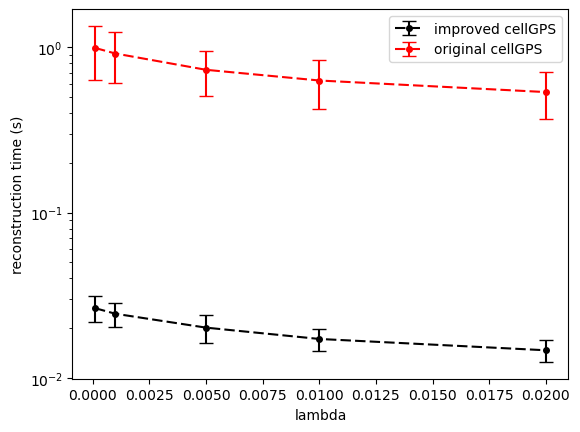

In [5]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

x_values = lambda0_values
backprop_values, original_values = Comparisons[:, :, 0].mean(axis=1), Comparisons[:, :, 1].mean(axis=1)
backprop_error, original_error = Comparisons[:, :, 0].std(axis=1), Comparisons[:, :, 1].std(axis=1)

fig, ax = plt.subplots()

er1 = ax.errorbar(x_values, backprop_values, yerr=backprop_error, marker="o", linestyle=(0, (5, 2)), capsize=5.0, markersize=4, color='black', label='improved cellGPS')
er2 = ax.errorbar(x_values, original_values, yerr=original_error, marker="o", linestyle=(0, (5, 2)) , capsize=5.0, markersize=4, color='red', label='original cellGPS')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('lambda')
ax.set_ylabel('reconstruction time (s)')

plt.show()

fig.savefig('time_comparison_lambda.png', dpi=400)

In [6]:
(Comparisons[:, :, 1].mean(axis=1) / Comparisons[:, :, 0].mean(axis=1))

array([37.38099887, 37.40487979, 36.1629871 , 36.47653159, 36.3528062 ])

# spline interval

## load

In [7]:
import pickle
    
with open('data/paper/Comparisons_lambda_0.005_knot_5_200.pkl', 'rb') as f:
    Comparisons = pickle.load(f)

knot_interval_values = [200, 150, 100, 50, 25, 5]

## analyze

In [8]:
dTime = np.abs(Comparisons[:, :, 0] - Comparisons[:, :, 0].mean(axis=1).reshape((-1, 1)))
for one_dTime in dTime:
    print(np.where(one_dTime.mean()*10 < one_dTime))

(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)
(array([ 95, 101]),)


In [9]:
outlier_index = np.array([95, 101])
Comparisons = np.delete(Comparisons, outlier_index, axis=1)

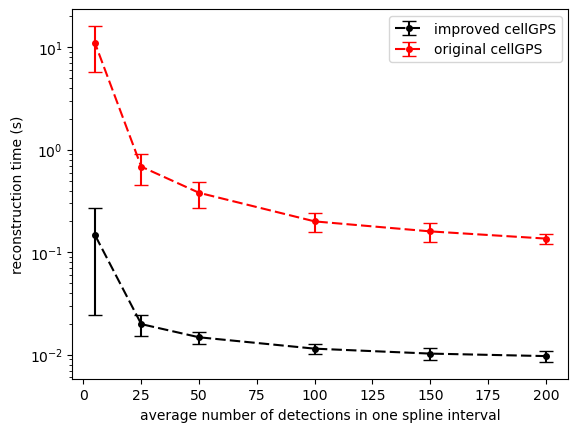

In [10]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

x_values = knot_interval_values
backprop_values, original_values = Comparisons[:, :, 0].mean(axis=1), Comparisons[:, :, 1].mean(axis=1)
backprop_error, original_error = Comparisons[:, :, 0].std(axis=1), Comparisons[:, :, 1].std(axis=1)

fig, ax = plt.subplots()

er1 = ax.errorbar(x_values, backprop_values, yerr=backprop_error, marker="o", linestyle=(0, (5, 2)), capsize=5.0, markersize=4, color='black', label='improved cellGPS')
er2 = ax.errorbar(x_values, original_values, yerr=original_error, marker="o", linestyle=(0, (5, 2)) , capsize=5.0, markersize=4, color='red', label='original cellGPS')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('average number of detections in one spline interval')
ax.set_ylabel('reconstruction time (s)')

plt.show()

fig.savefig('time_comparison_spline_interval.png', dpi=400)

## Reconstruction time fold by spline interval

Text(131.8386004977756, 0.5, 'reconstruction time fold [original / backpropagation]')

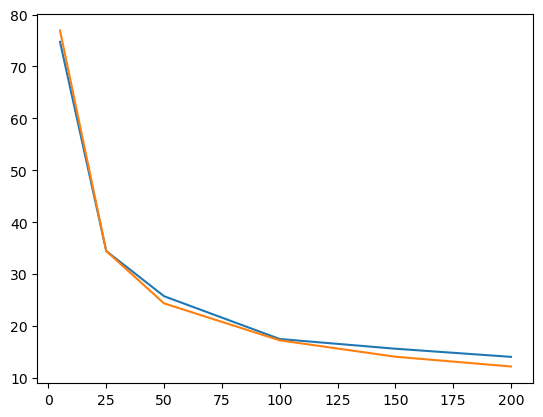

In [13]:
plt.plot(x_values, (Comparisons[:, :, 1].mean(axis=1) / Comparisons[:, :, 0].mean(axis=1)))
plt.plot(x_values,(172 / np.sqrt(np.array(x_values))))
ax.set_xlabel('average number of detections in one spline interval')
ax.set_ylabel('reconstruction time fold [original / backpropagation]')

In [12]:
(Comparisons[:, :, 1].mean(axis=1) / Comparisons[:, :, 0].mean(axis=1))

array([14.01867464, 15.5835331 , 17.45836739, 25.7053459 , 34.41009053,
       74.73008389])

# Accuracy demo figure